In [1]:
from scipy.ndimage.morphology import binary_hit_or_miss
from commonfunctions import *
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import skimage
from skimage.color import rgb2gray
from skimage.morphology import disk, square, rectangle as rect
import scipy.stats
from skimage import draw
from skimage.morphology import(binary_erosion, 
                               binary_dilation,
                               binary_closing,
                               skeletonize,
                               thin,
                               opening
                              )
from skimage.measure import find_contours
from skimage.filters import rank
from skimage.draw import rectangle
from skimage.filters import threshold_otsu, gaussian
from skimage import feature


In [2]:
import cv2
if ' ':
    print('hi')
    
def cv_show(image):
    image=np.uint8(image)
    cv2.imshow("image", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

hi


In [3]:
# omar do those
def which_number(num_image):
    """
    returns: zero is image wasn't a number
    or returns the number that it represents either
    1, 2, 3, 4, ...., 9
    
    arguments:
    num_image: this is an image of small size
    """
    pass

def which_symbol_division(sym_image):
    """
    returns which duration eg, if a/4 return 4, if a/8 return 8, if a/16, a/32 
    if not any one return 0
    
    arguments:
    sym_image: this is an image of small size
    """
    pass



In [4]:
# atia do this


def number_of_beams(sym_image):
    """
    returns the number of beams that are found in beaming symbols    
    arguments:
    sym_image: this is an image of small size
    """
    pass

def filled_holes_centers(char, radius):
    """
    returns: the centers of the filed holes found in the sym_image
    eg: [(x1,y1), (x2,y2)]
    arguments:
    sym_image: this is an image of small size where the filled_ovals
    """
    padded_char = padd_image(char)    
    erroded_image = cv2.erode(padded_char,kernel=disk(radius),iterations = 1)        
    b_boxes = get_external_bounding_boxes(erroded_image)
    centers = []
    for box in b_boxes:
        X,Y,w,h = box
        cx = X+w//2
        cy=Y+h//2
        centers.append((cx,cy))

    return centers

def which_accidentals(sym_image):
    """
    returns: accidental is found in that image
    returns '#' if # or '&' if b or ' '(space) if neutral '##' if X '&&' if bb
    or return ''(empty) or None if not any of these
    arguments:
    sym_image: this is an image of small size
    """
    pass

In [5]:
# classes
class staff_meta(object):
    division_height = -1
    line_thickness = -1
    staff_lines_y_coords = []
#notes_pitch = [
#    'e',    # bottom line (or the 5th from above)
#    'f',
#    'g',
#    'a',
#    'b',
#    'c',
#    'd'
#]
class notes_pitch(object):
    char =   ['e','f','g','a','b','c','d','e','f']
    factor = [ 1 , 1 , 1 , 1 , 1 , 2 , 2 , 2 , 2 ]


In [6]:
def get_trace_meta(image):
    if len(image.shape) != 2:
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    else:
        gray = image        
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    width = gray.shape[1]//5
    # Remove horizontal
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (width,1))

    # thresh = cv2.Canny(thresh, 30, 200) 
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    division_height=0
    h_max = 1
    bounding_rects = []
    for c in cnts:
        bounding_rects.append(cv2.boundingRect(c))

    for b_rect in bounding_rects:
        X,Y,w,h = b_rect
        if h > h_max:
            h_max = h
    def contour_y(c):
        return c[1]
    bounding_rects = sorted(bounding_rects, key=contour_y)
    lines_y_coordinates = [ b[1] for b in bounding_rects]
    div_height = bounding_rects[1][1] - bounding_rects[0][1]
    s_meta = staff_meta()
    s_meta.division_height = div_height
    s_meta.line_thickness = h_max
    s_meta.staff_lines_y_coords = lines_y_coordinates
    return s_meta

In [7]:
def padd_image(img):
    """
    this functions padds an image this is very important 
    when applying erosion as applying erosion to border 
    may result false postives
    """
    out_img = np.zeros((img.shape[0]+2,img.shape[1]+2), dtype=np.uint8)
    out_img[1:out_img.shape[0]-1,1:out_img.shape[1]-1] = img
    return out_img

In [8]:
def conv_255_true(image):
    image[image == 255] = True
    image[image == 0] = False
    return image
def remove_horizontal_wrapper(org_image, inv_image):
    # both org_image and inv_image must uint8 
    line_width, no_staf_1 = remove_horizontal_lines(org_image)
    no_staf_1 = conv_255_true(no_staf_1)
    no_staf = no_staf_1
    inv_image = conv_255_true(inv_image)
    no_staf = np.bitwise_and(no_staf, inv_image)
    return no_staf
def remove_horizontal_lines(image):
    if len(image.shape) != 2:
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    width = gray.shape[1]//5
    # Remove horizontal
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (width,1))

    # thresh = cv2.Canny(thresh, 30, 200) 
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    h_max = 1
    for c in cnts:
        X,Y,w,h = cv2.boundingRect(c)
        if h > h_max:
            h_max=h
    for c in cnts:   
#         print(h_max)
        cv2.drawContours(gray, [c], -1, 255, h_max)
#         cv2.imshow('result', gray)
#         cv2.waitKey()
#     cv2.destroyAllWindows()


    # Repair image
    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,h_max*3))
#     print("repair", repair_kernel)
    result = 255-cv2.morphologyEx(255 - gray, cv2.MORPH_CLOSE, repair_kernel, iterations=1)
#     cv2.imshow('result', gray)
#     cv2.waitKey()
    result = cv2.threshold(result, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    return h_max,result

In [9]:
def get_external_bounding_boxes(img):
    """
    this function takes and image and returns an array
    of bounding rectangle [(X1,Y1,W1,H1),(X2,Y2,W2,H2),....]
    where 
    Wi: is the width
    Hi: is the height
    """
    cnts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    bounding_rects = []
    for c in cnts:
        b_r = cv2.boundingRect(c)
        # X,Y,w,h = b_r
        bounding_rects.append(b_r)    # 
    def contour_x(c):
        return c[0]
    bounding_rects = sorted(bounding_rects, key=contour_x)
    return bounding_rects
def draw_external_bounding_boxes(img,b_rects):
    out = img.copy()
    for b_r in b_rects:
        X,Y,w,h = b_r
        out = cv2.rectangle(out, (X,Y), (X+w, Y+h),1,3)
    return out

In [10]:
# common functions
def binary_opening(img, selem):
    return binary_dilation(binary_erosion(img, selem=selem), selem=selem)
def get_bounding_boxes(img,box_aspect_ratio):
    """
    summary: this function returns the bounding boxes sorted according to x-min
    parameter:
    img: is a binary image for which to find the contours 
    aspect_ratio: is a tuple where (low_aspect_ratio,high_aspect_ratio)
    """
    contours = find_contours(img,.8, fully_connected="low")
    bounding_boxes=[]
    for contour in contours:
        Xmin= np.min(contour[:,1])
        Xmax=np.max(contour[:,1]) 
        Ymin=np.min(contour[:,0])
        Ymax = np.max(contour[:,0])
        if(Ymax-Ymin != 0):
            aspect_ratio = (Xmax-Xmin)/(Ymax-Ymin)
        else:
            aspect_ratio = 3000
            
        if aspect_ratio >= box_aspect_ratio[0] and aspect_ratio <= box_aspect_ratio[1]:
            bounding_boxes.append([int(round(Xmin)),int(round(Xmax)),int(round(Ymin)),int(round(Ymax))])
    
    
    def x_min(shape):
        return shape[0]             

    bounding_boxes = sorted(bounding_boxes, key=x_min)
    return bounding_boxes
#     no_duplicated_boxes=[bounding_boxes[0]]
#     for i in range(1, len(bounding_boxes)):
#         pre_box=bounding_boxes[i-1]
#         curr_box = bounding_boxes[i]
#         if curr_box[0] >= pre_box[0] and curr_box[1] <= pre_box[1] and curr_box[2] >= pre_box[2] and curr_box[3]<= pre_box[3]:
#             continue
#         else:
#             no_duplicated_boxes.append(curr_box)
#         print(pre_box," --- " ,curr_box)
#     return no_duplicated_boxes


def get_bounded_image(img,bounding_boxes):
    conte = np.zeros(img.shape)
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img.shape)
        rr = rr.astype(np.int)
        cc= cc.astype(np.int)
        conte[rr, cc] = 1 #set color white
    img2 = np.where(conte==1, img, 0)
    return img2
def draw_bounding_boxes(img,bounding_boxes):
    conte = np.zeros(img.shape)
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img.shape)
        rr = rr.astype(np.int)
        cc= cc.astype(np.int)
        conte[rr, cc] = 1 #set color white
    img2 = np.where(conte==1, img, 0)
    show_images([conte,img2], ['bounding_boxes','original segmented'])


In [11]:
# images_paths = ['images/music1.JPG', 'images/32_sheet_001.jpg','images/8th_Sheet1.jpeg']
# images_paths = ['test-cases/01.png','test-cases/02.png','images/music1.JPG', 'images/32_sheet_001.jpg','images/8th_Sheet1.jpeg']
images_paths = [ f"test-cases/0{i+1}.png" for i in range(9)]

original_image = io.imread(images_paths[1])
gray_image = rgb2gray(original_image)
show_images([gray_image], ['gray'])
binary_image = binarize(gray_image)
inverted_image = 255 - binary_image

inverted_image[:, inverted_image.shape[1]-1]=0
rows=1
cols=original_image.shape[1] // 4
selem = rect(rows,cols)
erroded_img = binary_erosion(inverted_image,selem=selem)

rows=1
cols=original_image.shape[1] // 4
selem = rect(rows,cols)
erroded_img2 = binary_dilation(erroded_img, selem=selem)
# inverted_image2 = inverted_image - erroded_img2

show_images([erroded_img2], ['erroded2'])
print(erroded_img)
rows = original_image.shape[0] // 8
cols = 1
selem = rect(rows,cols)
closed_img  = binary_closing(erroded_img2, selem = selem)


# closed_img  = binary_closing(closed_img, selem = selem)
show_images([inverted_image,erroded_img2,closed_img],['original image','erroded-dilated','closed'])

staffs_area = np.sum(erroded_img2)
print(staffs_area)

FileNotFoundError: No such file: '/home/omar/CMP3/Computer Vision/music-notes-reader/test-cases/02.png'

In [129]:
#  calculate the trace bounding boxes
trace_bounding_boxes = get_bounding_boxes(closed_img,(5,4000))
# print(trace_bounding_boxes)
bigger_trace_bounding_boxes = []
trace_images_array = []
division_height=0
trace_height = 0
for box in trace_bounding_boxes:
    trace_height = box[3]-box[2]
    trace_width = box[1] - box[0]
    division_height = (trace_height)/4
    division_height = int(np.ceil(division_height)) 
#     division_height *=2
    [Xmin, Xmax, Ymin, Ymax] = [int(round(x)) for x in box]
    Ymin -= 2 * division_height
    Ymin = Ymin if Ymin >0 else 0
    Ymax += 2 * division_height
    bigger_trace_bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])
    trace_images_array.append(gray_image[Ymin:Ymax,Xmin:Xmax])
staff_length = bigger_trace_bounding_boxes

# print(staffs_area, trace_width)

# print(staffs_area // (len(bigger_trace_bounding_boxes) * 5 *trace_width ))

# print(bigger_trace_bounding_boxes)
# print(inverted_image.shape)

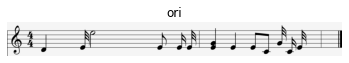

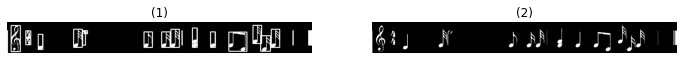

[(0, 42, 2, 110), (20, 17, 46, 128), (93, 79, 25, 32), (93, 43, 25, 31), (102, 76, 1, 1), (111, 79, 1, 1), (111, 76, 1, 1), (155, 60, 23, 74), (331, 35, 43, 89), (376, 42, 14, 71), (385, 42, 15, 15), (681, 48, 42, 76), (769, 48, 42, 76), (815, 35, 42, 89), (870, 42, 1, 71), (922, 29, 24, 95), (1012, 48, 24, 76), (1103, 49, 90, 94), (1223, 16, 43, 89), (1261, 67, 49, 76), (1314, 35, 42, 89), (1422, 42, 1, 71), (1500, 42, 4, 71), (1508, 42, 9, 71)]
width: 2, height: 110, division_height: 19
b_boxes  []


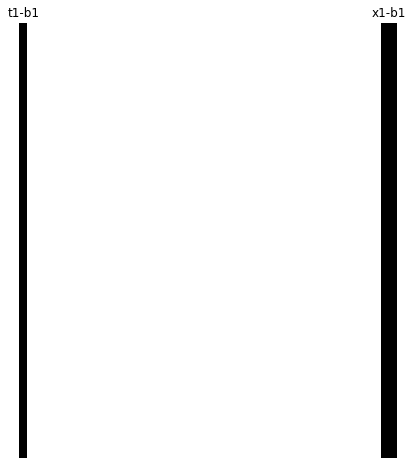

width: 46, height: 128, division_height: 19
b_boxes  []


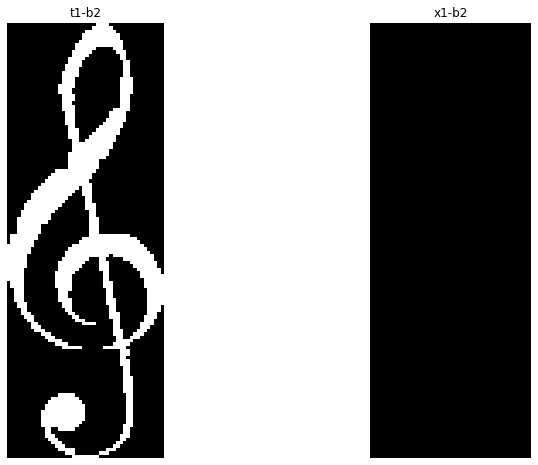

width: 25, height: 32, division_height: 19
b_boxes  []


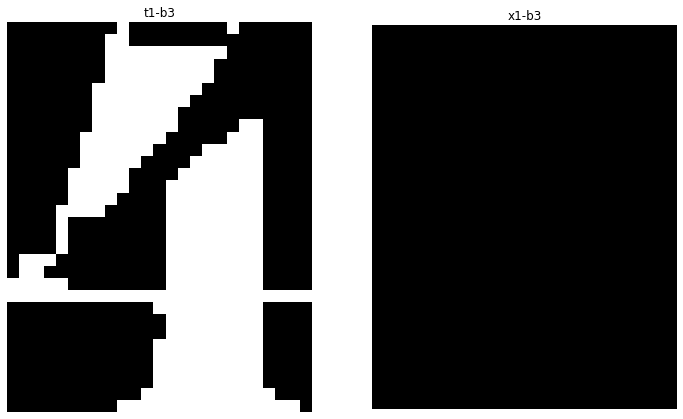

width: 25, height: 31, division_height: 19
b_boxes  []


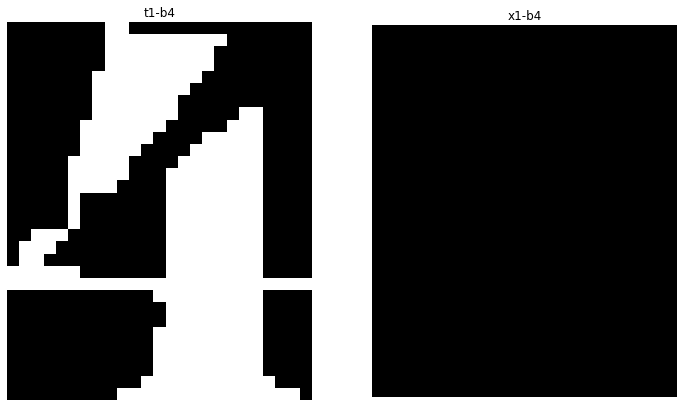

width: 1, height: 1, division_height: 19
b_boxes  []


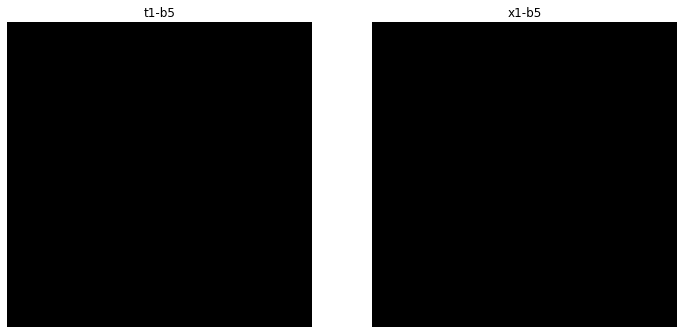

width: 1, height: 1, division_height: 19
b_boxes  []


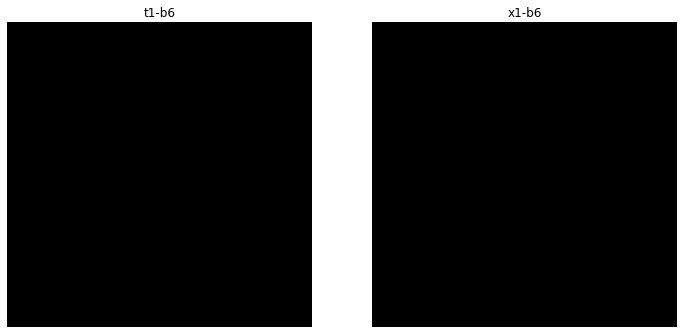

width: 1, height: 1, division_height: 19
b_boxes  []


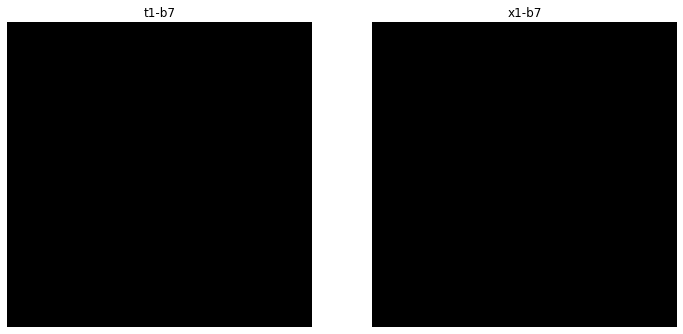

width: 23, height: 74, division_height: 19
b_boxes  [(7, 64, 10, 5)]


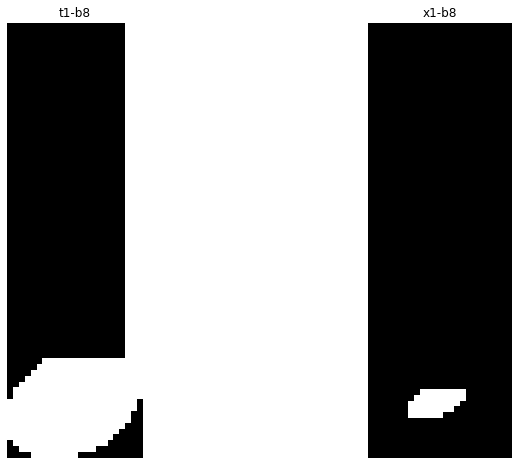

width: 43, height: 89, division_height: 19
b_boxes  [(8, 77, 10, 7)]


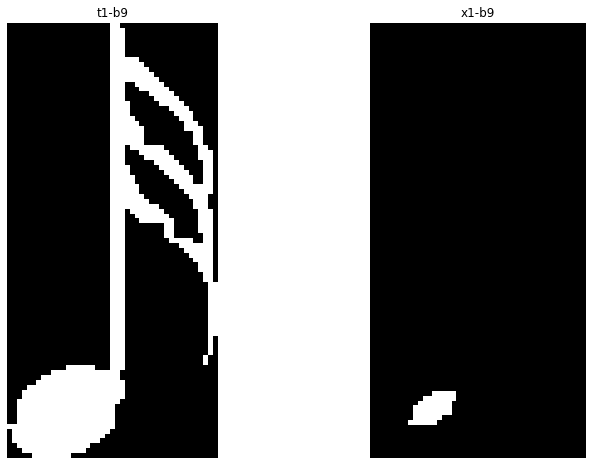

width: 14, height: 71, division_height: 19
b_boxes  []


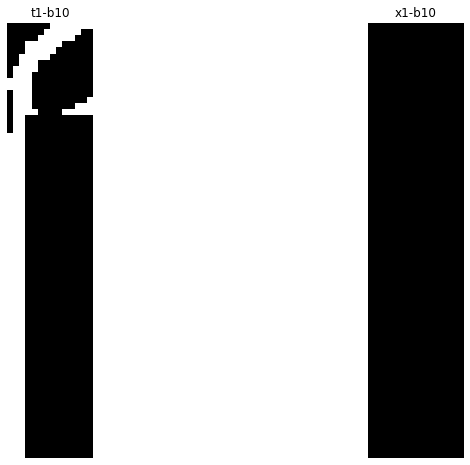

width: 15, height: 15, division_height: 19
b_boxes  []


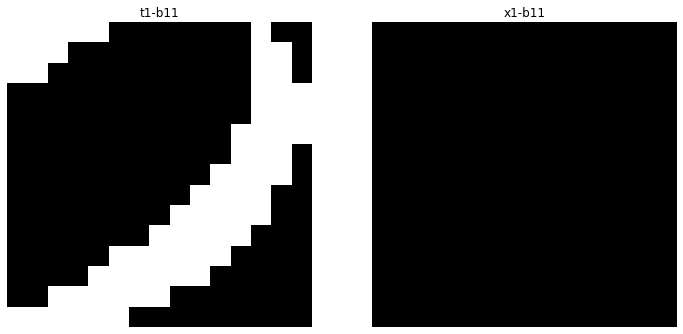

width: 42, height: 76, division_height: 19
b_boxes  [(7, 64, 11, 7)]


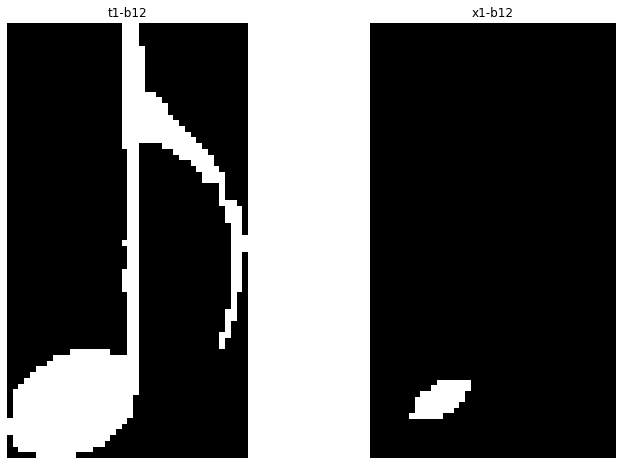

width: 42, height: 76, division_height: 19
b_boxes  [(8, 64, 10, 7)]


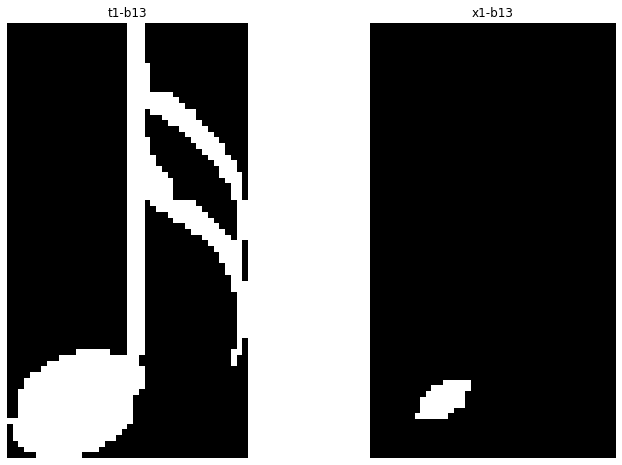

width: 42, height: 89, division_height: 19
b_boxes  [(7, 77, 10, 7)]


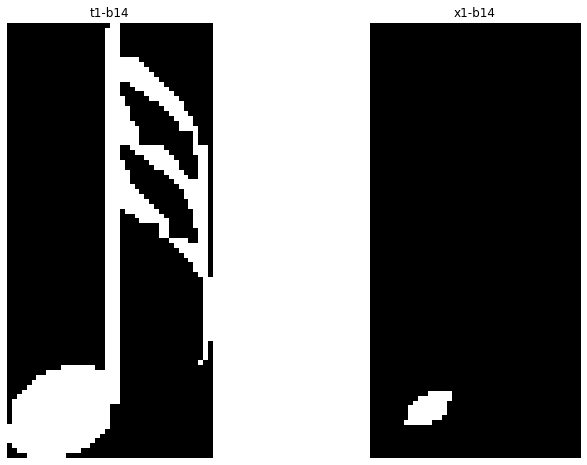

width: 1, height: 71, division_height: 19
b_boxes  []


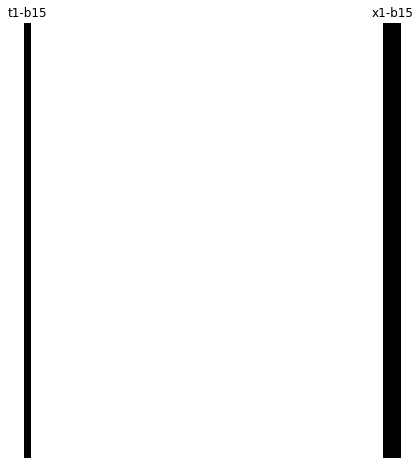

width: 24, height: 95, division_height: 19
b_boxes  [(7, 64, 12, 8), (8, 81, 10, 9)]


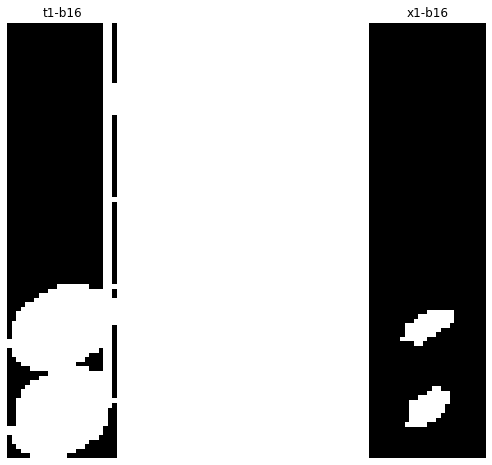

width: 24, height: 76, division_height: 19
b_boxes  [(8, 64, 10, 7)]


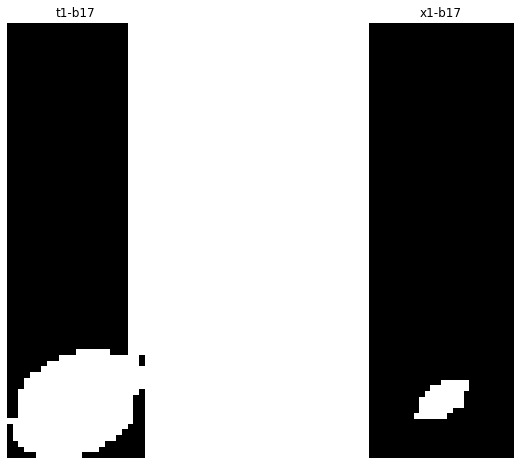

width: 90, height: 94, division_height: 19
b_boxes  [(7, 63, 10, 7), (67, 82, 11, 7)]


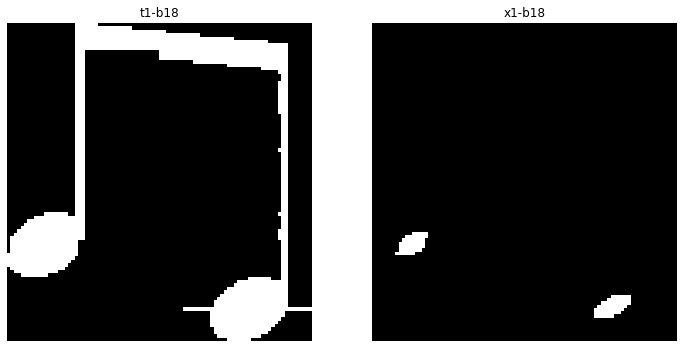

width: 43, height: 89, division_height: 19
b_boxes  [(7, 77, 11, 7)]


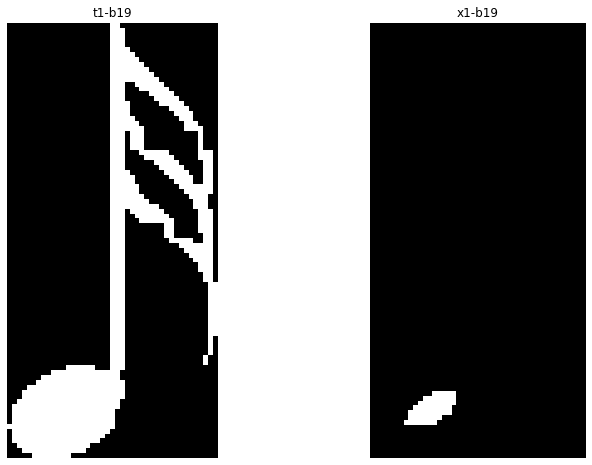

width: 49, height: 76, division_height: 19
b_boxes  [(15, 64, 11, 7)]


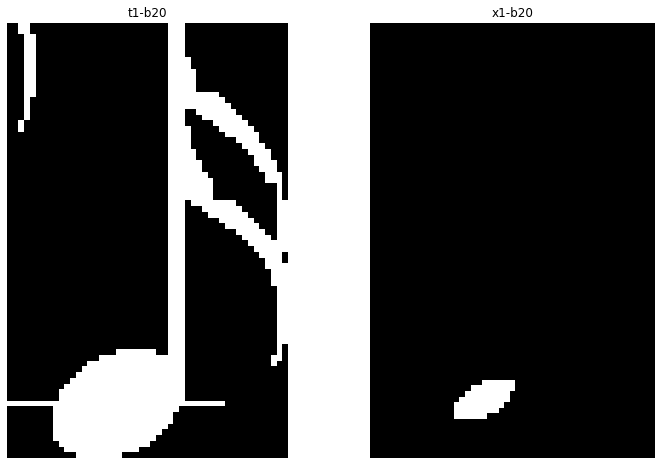

width: 42, height: 89, division_height: 19
b_boxes  [(7, 77, 11, 7)]


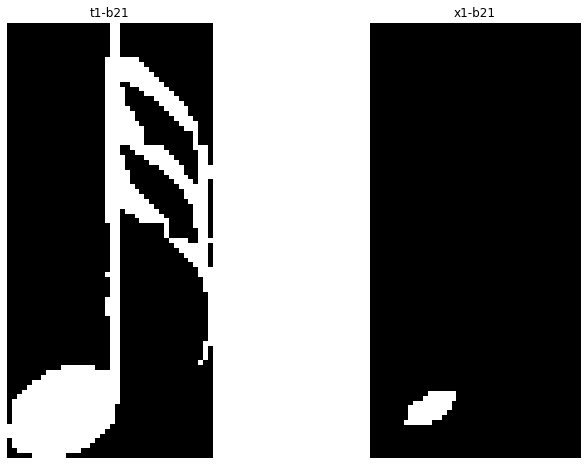

width: 1, height: 71, division_height: 19
b_boxes  []


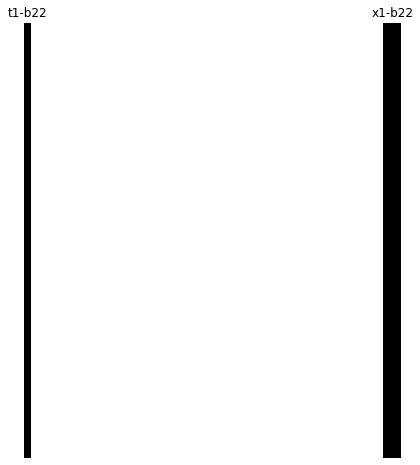

width: 4, height: 71, division_height: 19
b_boxes  []


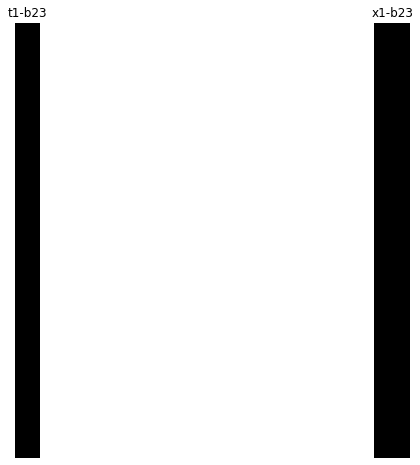

width: 9, height: 71, division_height: 19
b_boxes  []


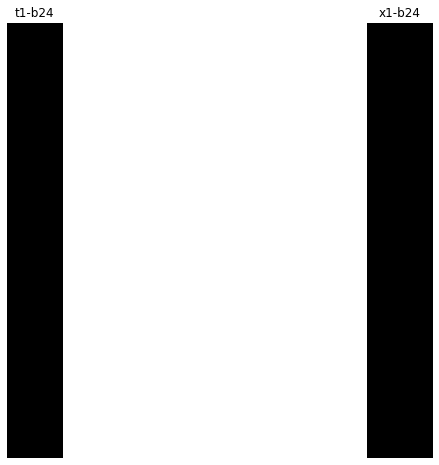

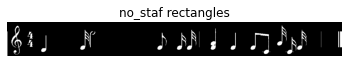

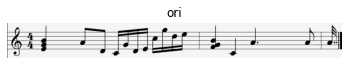

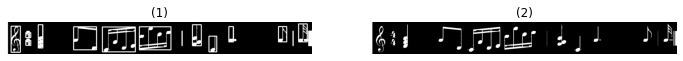

[(0, 0, 2, 157), (20, 20, 46, 128), (93, 90, 25, 24), (93, 52, 25, 24), (98, 83, 13, 14), (98, 45, 13, 14), (155, 13, 23, 114), (331, 23, 114, 113), (474, 24, 164, 122), (658, 23, 157, 113), (870, 44, 1, 72), (922, 13, 44, 103), (1004, 69, 39, 77), (1103, 22, 23, 75), (1131, 85, 7, 6), (1350, 22, 41, 75), (1422, 44, 1, 72), (1450, 9, 43, 88), (1479, 85, 7, 6), (1488, 85, 7, 6), (1500, 44, 4, 72), (1508, 44, 9, 72)]
width: 2, height: 157, division_height: 19
b_boxes  []


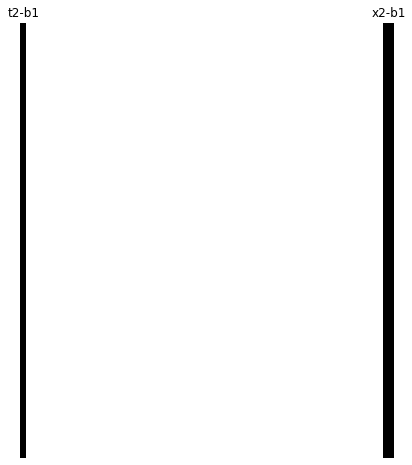

width: 46, height: 128, division_height: 19
b_boxes  []


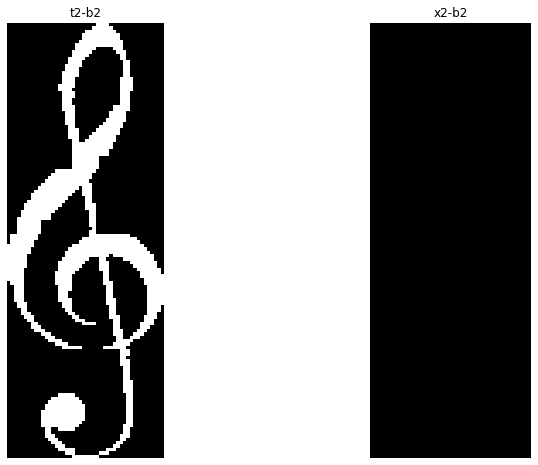

width: 25, height: 24, division_height: 19
b_boxes  []


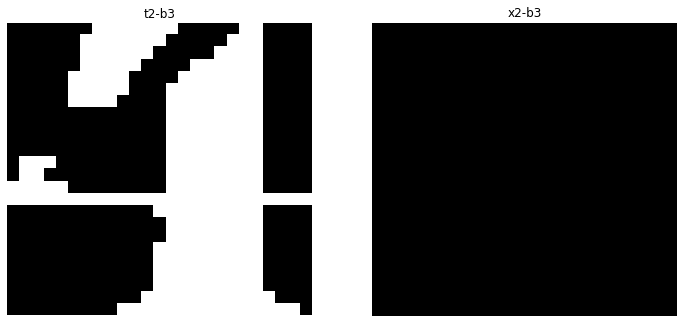

width: 25, height: 24, division_height: 19
b_boxes  []


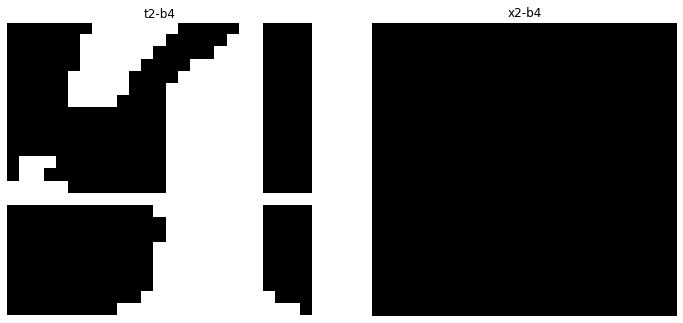

width: 13, height: 14, division_height: 19
b_boxes  []


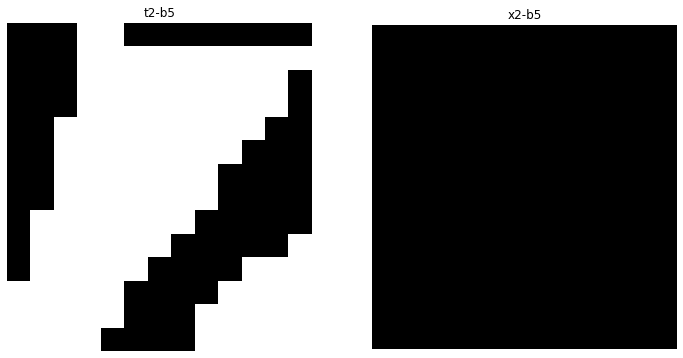

width: 13, height: 14, division_height: 19
b_boxes  []


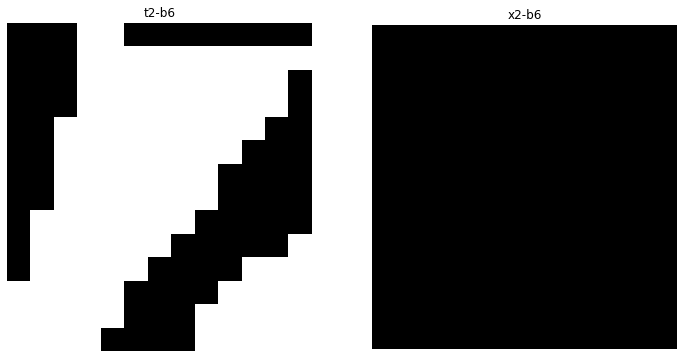

width: 23, height: 114, division_height: 19
b_boxes  [(7, 100, 10, 9), (7, 81, 11, 10), (7, 64, 11, 8)]


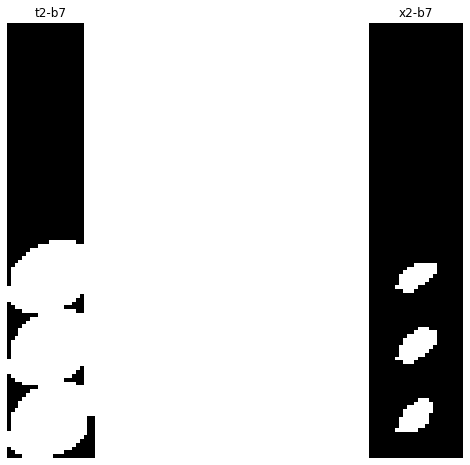

width: 114, height: 113, division_height: 19
b_boxes  [(8, 66, 10, 3), (98, 104, 10, 4)]


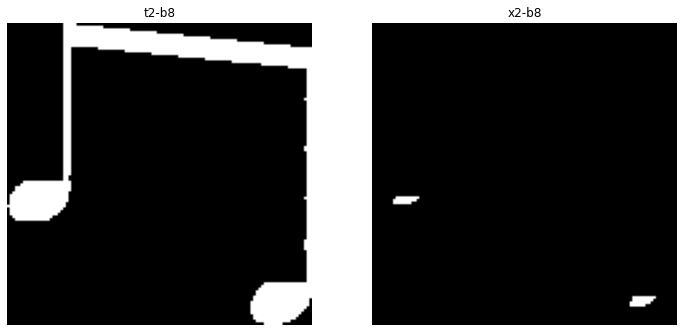

width: 164, height: 122, division_height: 19
b_boxes  [(15, 110, 11, 7), (60, 72, 10, 7), (104, 103, 10, 4), (148, 91, 10, 7)]


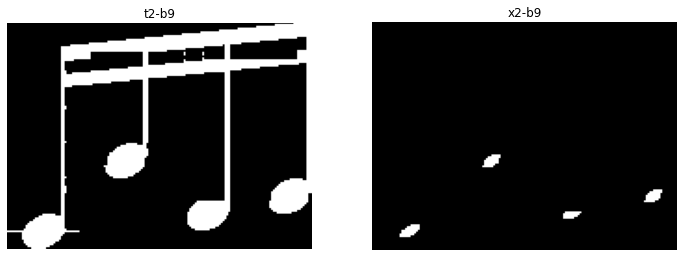

width: 157, height: 113, division_height: 19
b_boxes  [(9, 47, 10, 3), (53, 7, 10, 5), (97, 35, 10, 7), (142, 28, 10, 3)]


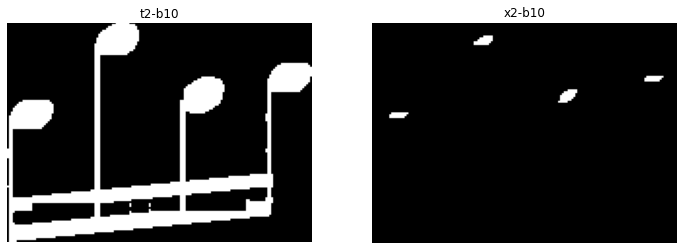

width: 1, height: 72, division_height: 19
b_boxes  []


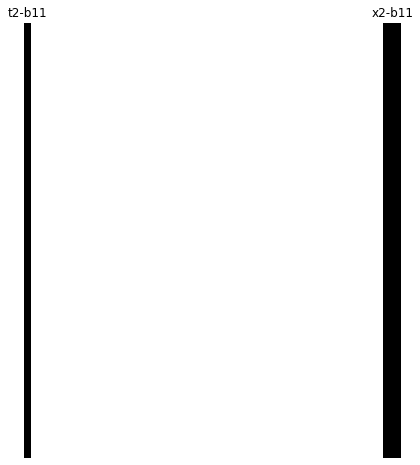

width: 44, height: 103, division_height: 19
b_boxes  [(7, 95, 10, 3), (8, 64, 11, 7), (27, 83, 12, 7)]


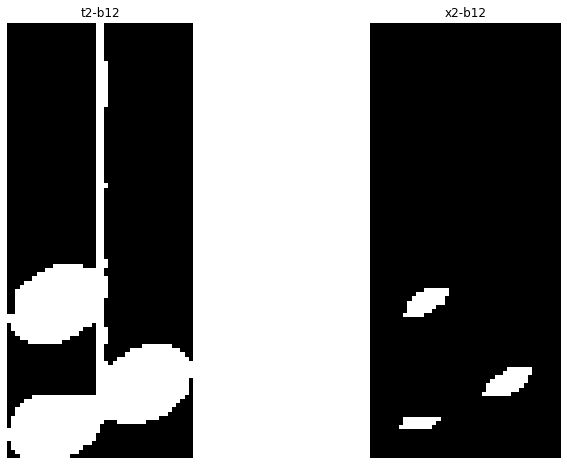

width: 39, height: 77, division_height: 19
b_boxes  [(15, 65, 12, 7)]


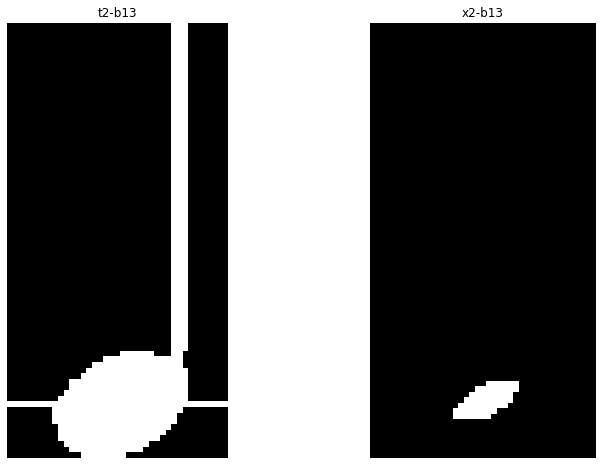

width: 23, height: 75, division_height: 19
b_boxes  [(7, 67, 10, 3)]


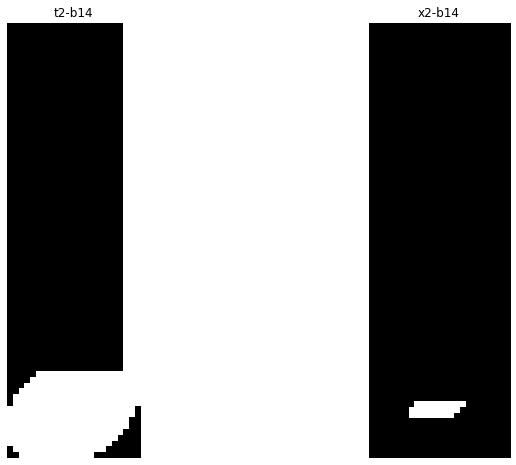

width: 7, height: 6, division_height: 19
b_boxes  []


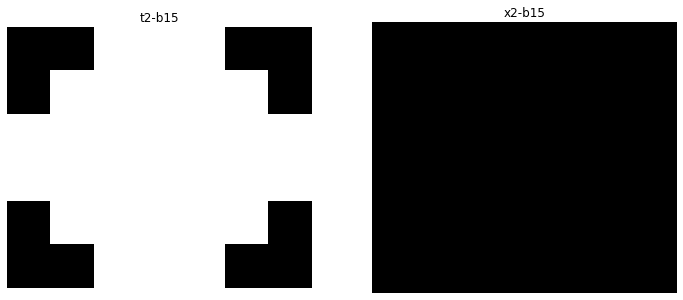

width: 41, height: 75, division_height: 19
b_boxes  [(7, 67, 10, 3)]


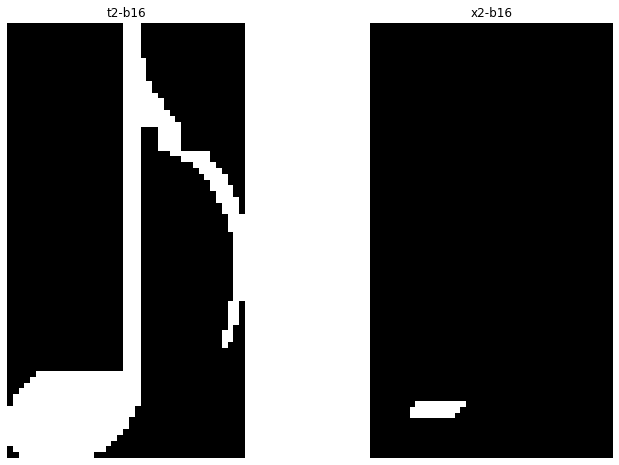

width: 1, height: 72, division_height: 19
b_boxes  []


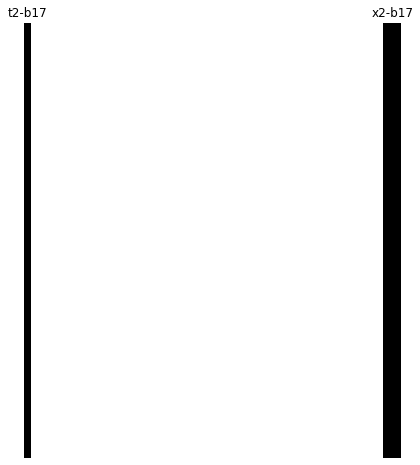

width: 43, height: 88, division_height: 19
b_boxes  [(8, 80, 10, 3)]


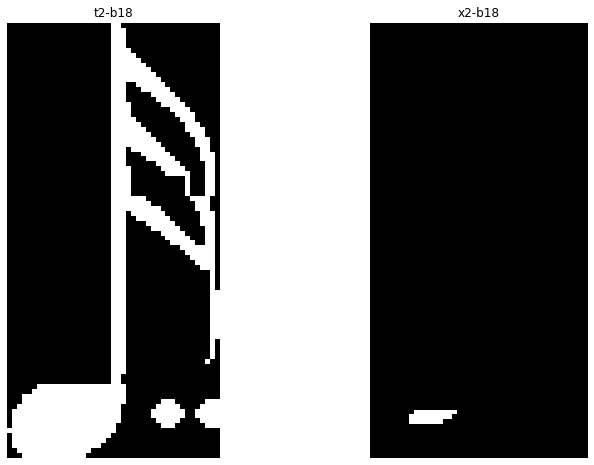

width: 7, height: 6, division_height: 19
b_boxes  []


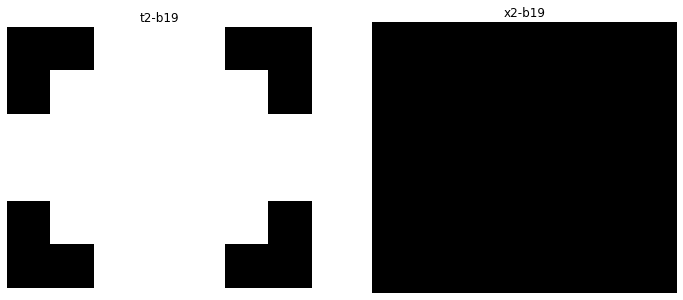

width: 7, height: 6, division_height: 19
b_boxes  []


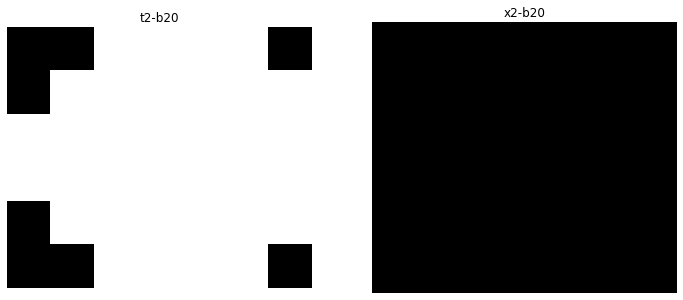

width: 4, height: 72, division_height: 19
b_boxes  []


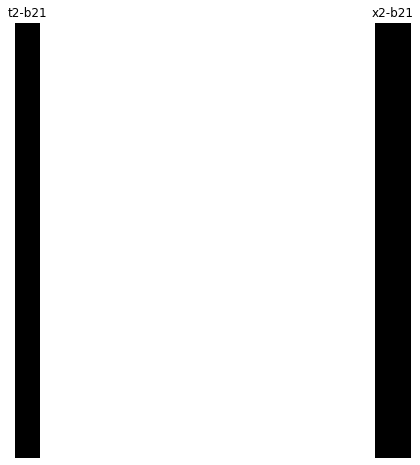

width: 9, height: 72, division_height: 19
b_boxes  []


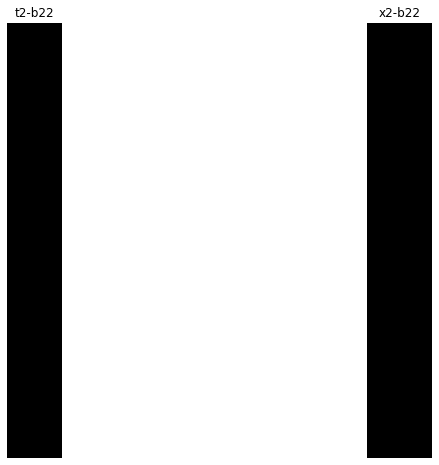

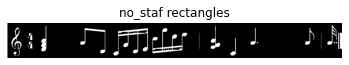

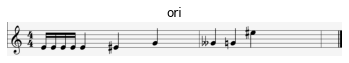

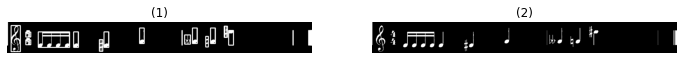

[(0, 0, 2, 113), (20, 17, 46, 128), (93, 87, 25, 24), (93, 49, 25, 24), (98, 80, 13, 14), (98, 42, 13, 14), (155, 48, 156, 76), (331, 48, 24, 76), (459, 86, 17, 57), (482, 48, 24, 76), (659, 29, 23, 76), (870, 41, 1, 72), (883, 63, 29, 45), (922, 29, 24, 76), (988, 70, 13, 52), (1012, 29, 24, 76), (1080, 20, 16, 55), (1102, 41, 24, 72), (1422, 41, 1, 72), (1500, 41, 4, 72), (1508, 41, 9, 72)]
width: 2, height: 113, division_height: 19
b_boxes  []


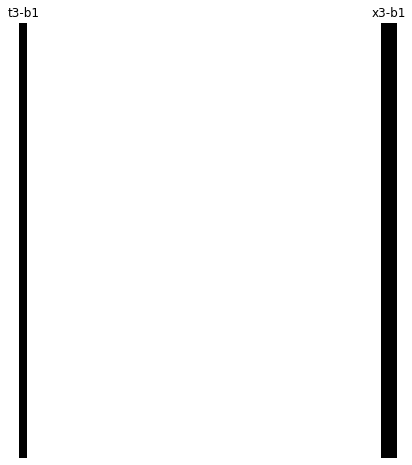

width: 46, height: 128, division_height: 19
b_boxes  []


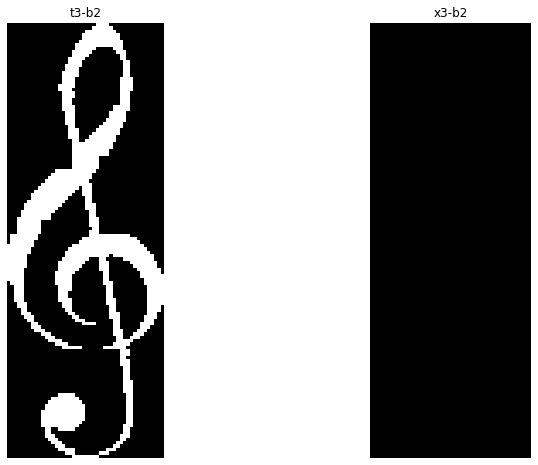

width: 25, height: 24, division_height: 19
b_boxes  []


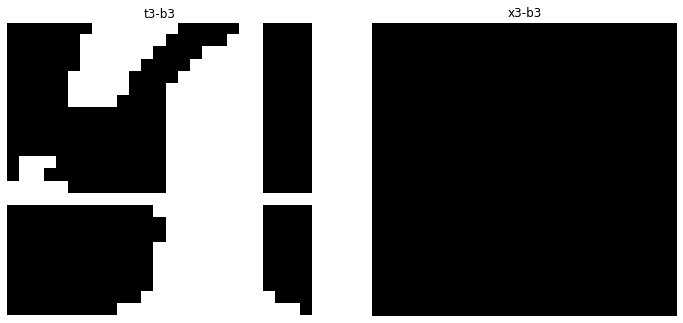

width: 25, height: 24, division_height: 19
b_boxes  []


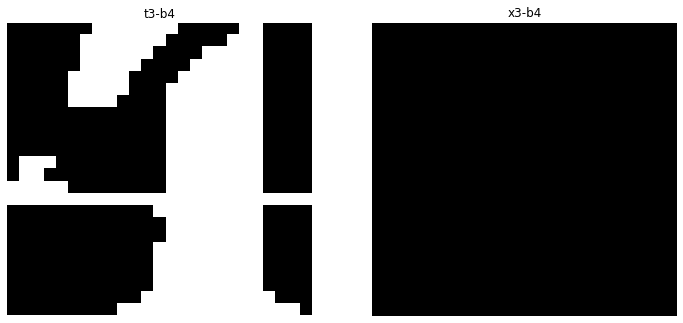

width: 13, height: 14, division_height: 19
b_boxes  []


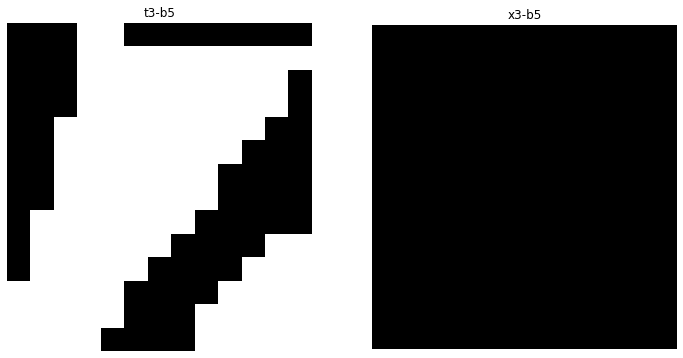

width: 13, height: 14, division_height: 19
b_boxes  []


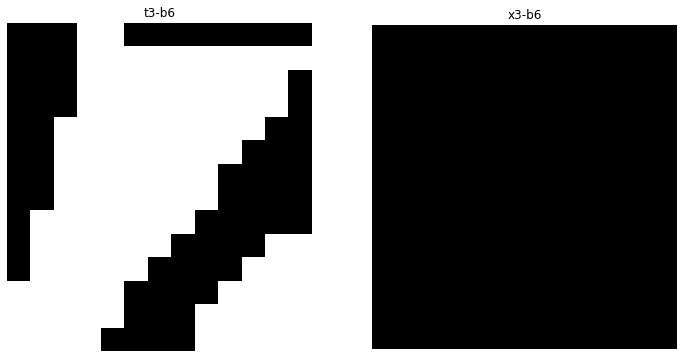

width: 156, height: 76, division_height: 19
b_boxes  [(7, 64, 10, 7), (51, 64, 11, 7), (95, 64, 11, 7), (140, 64, 10, 7)]


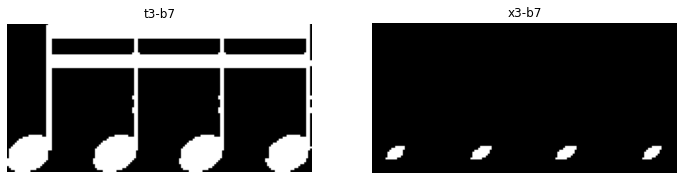

width: 24, height: 76, division_height: 19
b_boxes  [(8, 64, 10, 7)]


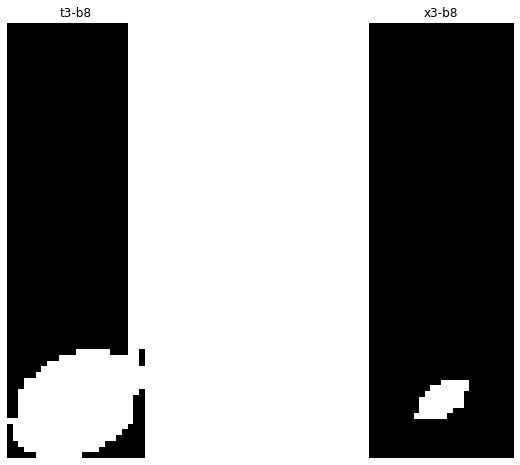

width: 17, height: 57, division_height: 19
b_boxes  []


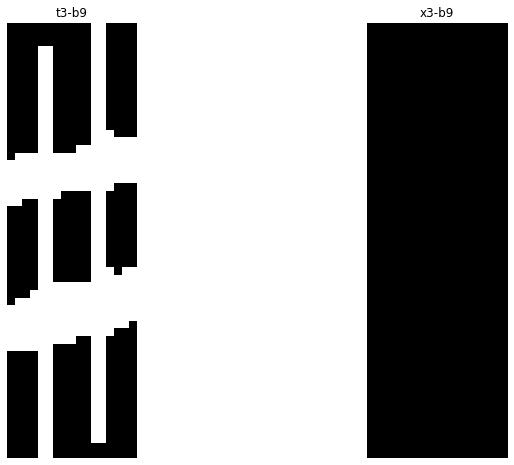

width: 24, height: 76, division_height: 19
b_boxes  [(8, 64, 10, 7)]


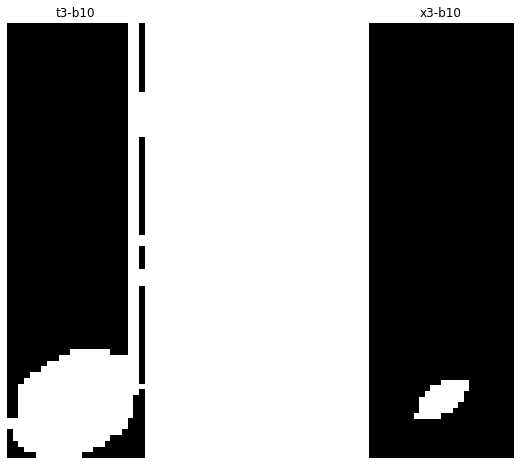

width: 23, height: 76, division_height: 19
b_boxes  [(7, 64, 11, 7)]


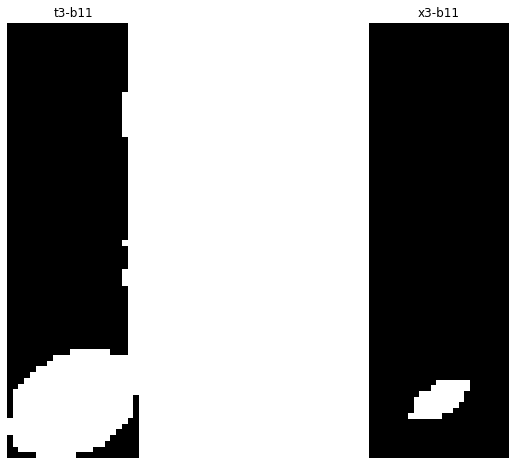

width: 1, height: 72, division_height: 19
b_boxes  []


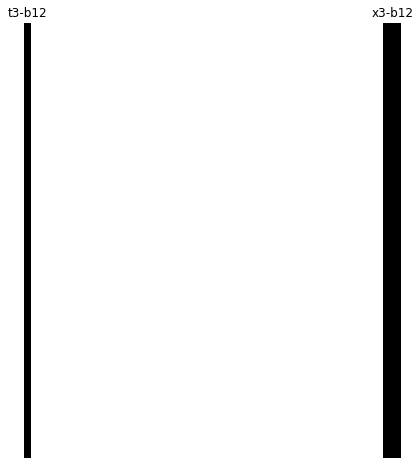

width: 29, height: 45, division_height: 19
b_boxes  []


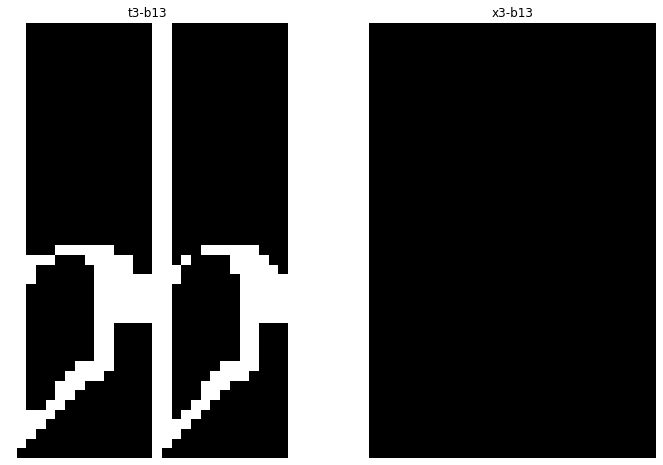

width: 24, height: 76, division_height: 19
b_boxes  [(8, 64, 10, 7)]


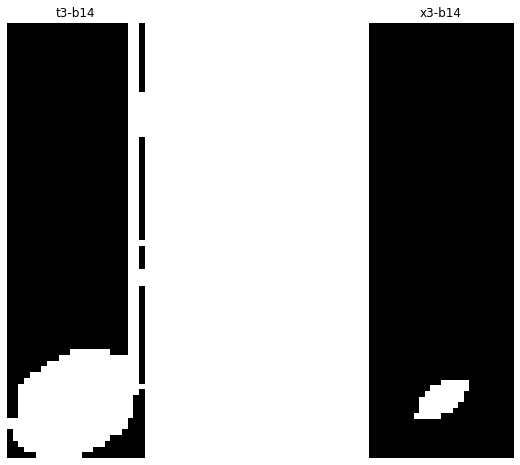

width: 13, height: 52, division_height: 19
b_boxes  []


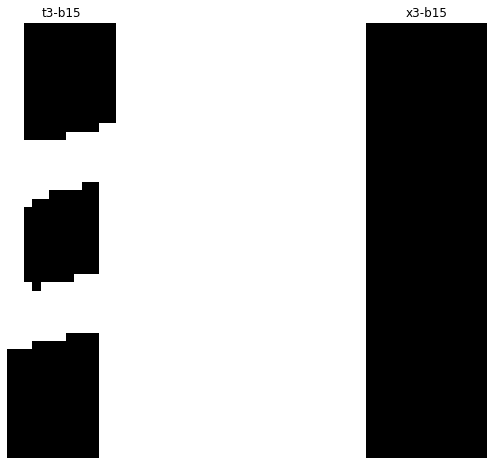

width: 24, height: 76, division_height: 19
b_boxes  [(8, 64, 10, 7)]


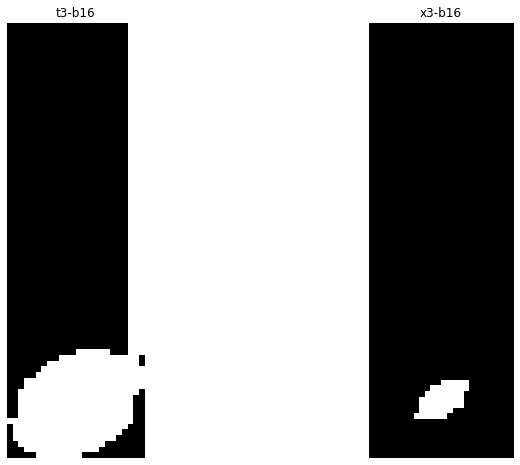

width: 16, height: 55, division_height: 19
b_boxes  []


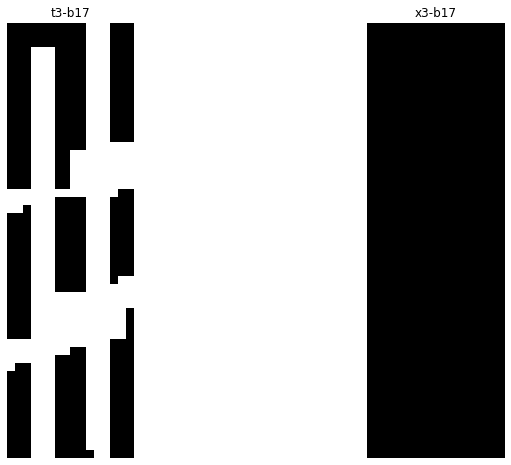

width: 24, height: 72, division_height: 19
b_boxes  [(8, 7, 10, 3)]


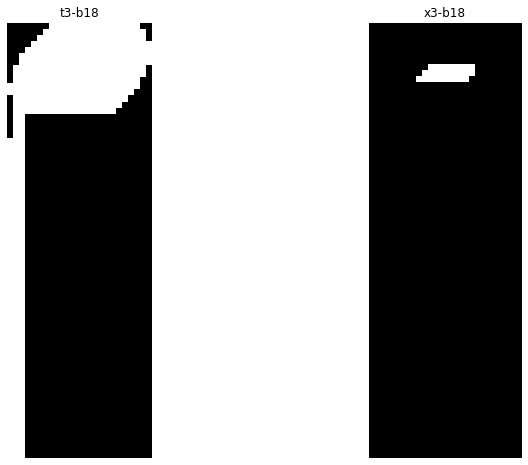

width: 1, height: 72, division_height: 19
b_boxes  []


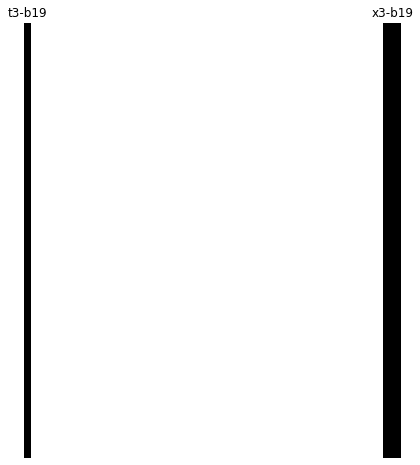

width: 4, height: 72, division_height: 19
b_boxes  []


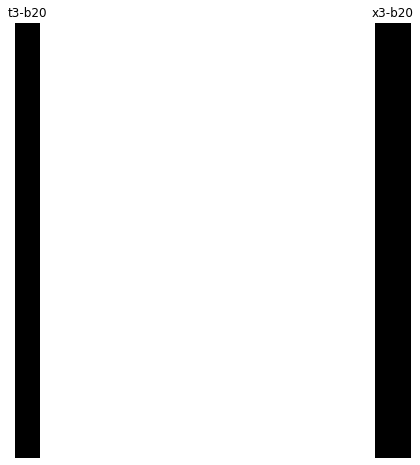

width: 9, height: 72, division_height: 19
b_boxes  []


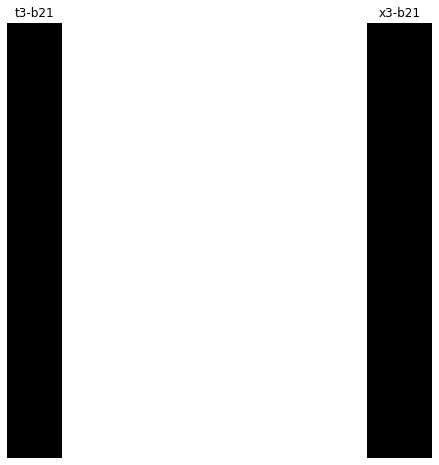

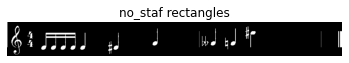

In [180]:
# for each trace segment the individual characters
no_horizontal_staff_images = []
staff_images = []
gray_staff_images=[]
sh = lambda x: print ("shape is ",x.shape)
line_height = 3

for i, trace in enumerate(bigger_trace_bounding_boxes):
    [Xmin, Xmax, Ymin, Ymax] = [x for x in trace]
    show_images([original_image[Ymin:Ymax,Xmin:Xmax]], ['ori'])
    no_staf=remove_horizontal_wrapper(original_image[Ymin:Ymax,Xmin:Xmax],inverted_image[Ymin:Ymax,Xmin:Xmax].astype(np.uint8) )
    no_horizontal_staff_images.append(no_staf)
    # show_images([no_staf], ['no_staf'])
    
    char_boxes = get_external_bounding_boxes(no_staf)
    out = draw_external_bounding_boxes(no_staf, char_boxes)
    show_images([out,no_staf])
    print(char_boxes)
    # io.imsave('test.jpg', no_staf*255)
    # break
    j=0
    chars = []
    trace_info: staff_meta = get_trace_meta(original_image[Ymin:Ymax,Xmin:Xmax])
    # print(trace_info.__dict__)
    
    for box in char_boxes:
        [Xmin, Ymin, W, H] = [x for x in box]
        # remove blank or noisy area that is less than a line of pixels
        char = no_staf[Ymin:Ymin+H,Xmin:Xmin+W]
        # reject noise before appending
        # 1. box area == 0
        if(np.sum(char) == 0):
            continue
        print("width: {}, height: {}, division_height: {}".format(W,H,trace_info.division_height))
        # print(filled_holes_centers(char,trace_info.division_height))
        
        radius = trace_info.division_height//3
        padded_char = padd_image(char)
        
        erroded_image = cv2.erode(padded_char,kernel=disk(radius),iterations = 1)        
        b_boxes = get_external_bounding_boxes(erroded_image)
        
        centers = filled_holes_centers(char, radius)
        # print("centers ",centers)
        print("b_boxes ",b_boxes)

        show_images([char,erroded_image],[f't{i+1}-b{j+1}',f'x{i+1}-b{j+1}'])
        chars.append(char)
        # 
        j+=1
    show_images([no_staf], ['no_staf rectangles'])

    staff_images.append(chars)


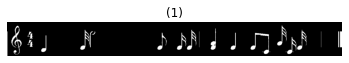

In [131]:
show_images([no_horizontal_staff_images[0]])

In [165]:
for staff_chars in staff_images:
    j=0
    j+=1
    for char in staff_chars:
        i=0
        i+=1
        # show_images([char],[f"char {j}-{i}"])
        
        
        
        

In [ ]:
# USING CONNNECTED COMPONENETS

ret, labels = cv2.connectedComponents(binary)
print("hi")

In [ ]:

from skimage import data
from skimage.viewer import ImageViewer

image = original_image
viewer = ImageViewer(image)
viewer.show()

In [ ]:
import cv2
def get_avg_contour_areas(contours):
    # returns the areas of all contours as list
    all_areas = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        all_areas.append(area)
    return  np.average(np.array(all_areas))


image = cv2.imread('images/8th_Sheet1.jpeg')
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Remove horizontal
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))

# thresh = cv2.Canny(thresh, 30, 200) 
detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# print(cnts)
cont_areas = get_avg_contour_areas(cnts)
print("avg" , cont_areas)
for c in cnts:
    print(len(c))
    cv2.drawContours(image, [c], -1, (255,255,255), 2)
    print(cv2.boundingRect(c))
    cv2.imshow('result', image)
    cv2.waitKey()
cv2.destroyAllWindows()

# Repair image
repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
print("repair", repair_kernel)
result = cv2.morphologyEx(255 - image, cv2.MORPH_CLOSE, repair_kernel, iterations=1)
kernel = np.ones((1,15),np.uint8)
# er = cv2.dilate(result,kernel,iterations = 1)


showHist(result)
cv2.imshow('thresh', thresh)
cv2.imshow('detected_lines', detected_lines)
cv2.imshow('image', image)
# cv2.imshow('er', er)
cv2.imshow('result', result)
cv2.waitKey()
cv2.destroyAllWindows()


In [ ]:
import cv2
def get_avg_contour_areas(contours):
    # returns the areas of all contours as list
    all_areas = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        all_areas.append(area)
    return  np.average(np.array(all_areas))
# images_paths = [ f"test-cases/0{i+1}.png" for i in range(9)]
images_paths = ['test-cases/01.png','test-cases/02.png','images/music1.JPG', 'images/32_sheet_001.jpg','images/8th_Sheet1.jpeg']
for image_path in images_paths:
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    width = gray.shape[1]//5
    # Remove horizontal
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (width,1))

    # thresh = cv2.Canny(thresh, 30, 200) 
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    # print(cnts)
#     print("avg" , cont_areas)
    h_max = 1
    for c in cnts:
        X,Y,w,h = cv2.boundingRect(c)
        if h > h_max:
            h_max = h
       
    break   
    for c in cnts:   
#         print(h_max)
        cv2.drawContours(gray, [c], -1, 255, h_max)
        cv2.imshow('result', gray)
        cv2.waitKey()
    cv2.destroyAllWindows()


    # Repair image
    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,h_max*3))
#     print("repair", repair_kernel)
    result = cv2.morphologyEx(255 - gray, cv2.MORPH_CLOSE, repair_kernel, iterations=1)
    result = cv2.threshold(result, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    showHist(result)
    cv2.imshow('thresh', thresh)
    cv2.imshow('detected_lines', detected_lines)
    cv2.imshow('image', image)
    # cv2.imshow('er', er)
    cv2.imshow('result', result)
    cv2.waitKey()
    cv2.destroyAllWindows()


In [ ]:
import cv2
def get_avg_contour_areas(contours):
    # returns the areas of all contours as list
    all_areas = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        all_areas.append(area)
    return  np.average(np.array(all_areas))


image = cv2.imread('images/8th_Sheet1.jpeg')  
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
cv2.destroyAllWindows()
showHist(thresh)



In [ ]:
import cv2
images_paths = ['test-cases/01.png','test-cases/02.png','images/music1.JPG', 'images/32_sheet_001.jpg','images/8th_Sheet1.jpeg']
image_path = images_paths[0]
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED);
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# getting mask with connectComponents
ret, labels = cv2.connectedComponents(binary)
for label in range(1,ret):
    mask = np.array(labels, dtype=np.uint8)
    mask[labels == label] = 255
    cv2.imshow('component',mask)
    cv2.waitKey(0)

# getting ROIs with findContours
contours = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
for cnt in contours:
    (x,y,w,h) = cv2.boundingRect(cnt)
    ROI = image[y:y+h,x:x+w]
    cv2.imshow('ROI', ROI)
    cv2.waitKey(0)

cv2.destroyAllWindows()

In [ ]:

def get_external_bounding_boxes(img):
    """
    this function takes and image and returns an array
    of bounding rectangle [(X1,Y1,W1,H1),(X2,Y2,W2,H2),....]
    where 
    Wi: is the width
    Hi: is the height
    """
    cnts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    bounding_rects = []
    for c in cnts:
        b_r = cv2.boundingRect(c)
        # X,Y,w,h = b_r
        bounding_rects.append(b_r)    # 
    def contour_x(c):
        return c[0]
    bounding_rects = sorted(bounding_rects, key=contour_x)
    return bounding_rects
def draw_external_bounding_boxes(img,b_rects):
    out = img.copy()
    for b_r in b_rects:
        X,Y,w,h = b_r
        out = cv2.rectangle(out, (X,Y), (X+w, Y+h),1,3)
    return out
bounding_rects = get_external_bounding_boxes(no_staf)
out = draw_external_bounding_boxes(no_staf, bounding_rects)
show_images([no_staf, out])
print(bounding_rects)
for b_rect in bounding_rects:
    X,Y,W,H = b_rect
    print(box)
    show_images([no_staf[Y:Y+H,X:X+W]])
    # print(b_rect)
# show_images()


In [ ]:
def get_noteLine_depending_height(Charimg):
    trace_info: staff_meta = get_trace_meta(Charimg)#[Ymin:Ymax,Xmin:Xmax])
    radius = trace_info.division_height//3
    centers = filled_holes_centers(char, radius)
    x,y = cenetrs[0]
    i = 1
    while trace_info.staff_lines_y_coords[4] < y:
        i += 1
        y -= 3.5*(trace_info.division_height + trace_info.line_thickness)
    while trace_info.staff_lines_y_coords[0] > y:
        i -= 1
        y += 3.5*(trace_info.division_height + trace_info.line_thickness)
    startLine = -1
    endLine = -1
    factor = i
    j = 0
    while(j < 5):
        if y == trace_info.staff_lines_y_coords[j]:
            startLine = endLine = j
            print("its on line": notes_pitch[2*j])
            break
        elif y > trace_info.staff_lines_y_coords[j]:
            startLine = j - 1
            endLine = j
            print("its between: ",j-1," and ", j)
            break
        else:
            j += 1
return startLine,endLine,factor

def map_note(Charimg):
startLine,endLine,factor = get_noteLine_depending_height(Charimg)
obj: notes_pitch()
if startLine == endLine:
    return obj.notes_pitch[startLine*2], obj.factor[startLine*2] + factor
else:
    return obj.notes_pitch[startLine*2 + 1 ], obj.factor[startLine*2 + 1] + factor
